**Binary classification**

In [15]:
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore")

In [2]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

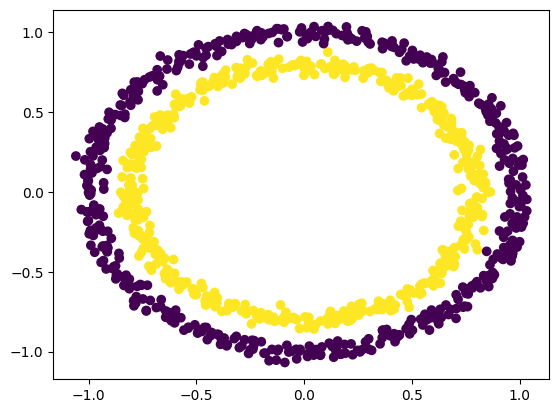

In [3]:
plt.scatter(x=X[:, 0], y=X[: , 1], c=y)

### checkin input and output shapes

In [4]:
X.shape, y.shape # this is not torch tensors

((1000, 2), (1000,))

In [5]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [6]:
y

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
        1., 0., 1., 1., 0., 1., 1., 0., 

**Split data into train and test set**

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [8]:
len(X_train), len(X_test)

(800, 200)

In [9]:
# creating a model
from torch import nn

**Building a model**

Let's build a mdel to classify our blue and red dots.

To do so, we want to:
1. Setup agonistic code so our code will run on a GPU
2. Construct a model(subclassing nn.Module)
3. Define a loss function and optimizer

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
device

'cuda'

In [12]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # creating layers for classifcation
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [13]:
model_0 = ClassificationModel().to(device)

In [14]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.0796, -0.1839],
                      [ 0.6797,  0.2715],
                      [ 0.2680, -0.6953],
                      [-0.1127,  0.0748],
                      [-0.5725,  0.0673]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3985,  0.3298,  0.1481,  0.4185,  0.5948], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2714,  0.1928,  0.3965, -0.3314, -0.3154]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2553], device='cuda:0'))])

In [16]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

In [17]:
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")

Length of predictions: 200, Shape: torch.Size([200, 1])


In [18]:
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")

Length of test samples: 200, Shape: torch.Size([200, 2])


In [19]:
print(f"First 10 predictions: \n{untrained_preds[:10]}")
print(f"First 10 labels: \n{y_test[:10]}")

First 10 predictions: 
tensor([[-0.9481],
        [-0.8673],
        [-0.7717],
        [-0.9997],
        [-0.1555],
        [-0.1109],
        [-0.3718],
        [-0.1931],
        [-0.7980],
        [-0.8551]], device='cuda:0')
First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


**setting up loass and optimisation function**

For regression models we use MAE or MSE for the loss function
for classification problems we should use Binary cross entropy for the binary classification and cross entropy loss for multiclass classification.

Loss functions measures how long the predictions are.

* For the loss function we are going to use `torch.nn.BECWithLogitsLoss)`.
* What's a logit?
* 

In [20]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [22]:
# calculate the accuracy - out of 100 examples what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

**Train a model**

1. Forward propagation 
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward(backward propagation)
5. Optimizer step(gradient descent)

How is our output going to be?
Raw logits -> prediction probabilities -> prediction labels
we can convert raw logits to prediction probabilities by passing them to some kind
of activation function (sigmoid for binary classification).
Then we can convert our model's prediction probabilities to prediction labels
by either rounding them or taking the argmax()

In [25]:
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

In [26]:
y_logits

tensor([[-0.9481],
        [-0.8673],
        [-0.7717],
        [-0.9997],
        [-0.1555]], device='cuda:0')

In [27]:
y_test

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.])

In [31]:
y_pred_prob = torch.sigmoid(y_logits) # turning logits to prediction probabilities

In [29]:
y_pred_prob

tensor([[0.2793],
        [0.2958],
        [0.3161],
        [0.2690],
        [0.4612]], device='cuda:0')

In [32]:
y_pred = torch.round(y_pred_prob) # turning prediction probabilities to prediction labels

In [34]:
print(torch.eq(y_pred.squeeze(), torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5].squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


In [41]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epoch_counts = []
loss_values = []
test_loss_values = []
epochs = 300

In [42]:
for epoch in range(epochs):
    # setup the training mode
    model_0.train()
    # forward propagate
    y_logits = model_0(X_train).squeeze()
    # convert logits to labels
    y_pred = torch.round(torch.sigmoid(y_logits))
    # calculate the loss 
    loss = loss_fn(y_logits, y_train)
    # calculate the accuracy
    acc = accuracy_fn(y_true=y_train, y_pred = y_pred)
    # prepare the backpropagation
    optimizer.zero_grad()
    # back propagate
    loss.backward()
    # gradient descent
    optimizer.step()
    # clear the enviroment for testing 
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc =  accuracy_fn(y_true=y_test, y_pred=test_pred)
    epoch_counts.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    if epoch % 10 == 0:
        print(f"Epoch{epoch} Loss {loss:.5f} Test loss{test_loss:.5f} Test accuracy: {test_acc:.2f}")

Epoch0 Loss 0.69527 Test loss0.69435 Test accuracy: 45.00
Epoch10 Loss 0.69497 Test loss0.69419 Test accuracy: 46.00
Epoch20 Loss 0.69471 Test loss0.69406 Test accuracy: 46.00
Epoch30 Loss 0.69450 Test loss0.69396 Test accuracy: 46.50
Epoch40 Loss 0.69431 Test loss0.69388 Test accuracy: 48.00
Epoch50 Loss 0.69415 Test loss0.69382 Test accuracy: 48.50
Epoch60 Loss 0.69401 Test loss0.69378 Test accuracy: 49.00
Epoch70 Loss 0.69389 Test loss0.69375 Test accuracy: 49.00
Epoch80 Loss 0.69378 Test loss0.69373 Test accuracy: 49.00
Epoch90 Loss 0.69369 Test loss0.69372 Test accuracy: 49.00
Epoch100 Loss 0.69361 Test loss0.69372 Test accuracy: 49.00
Epoch110 Loss 0.69354 Test loss0.69372 Test accuracy: 51.00
Epoch120 Loss 0.69347 Test loss0.69373 Test accuracy: 51.50
Epoch130 Loss 0.69342 Test loss0.69374 Test accuracy: 51.50
Epoch140 Loss 0.69337 Test loss0.69376 Test accuracy: 51.00
Epoch150 Loss 0.69333 Test loss0.69378 Test accuracy: 52.00
Epoch160 Loss 0.69329 Test loss0.69380 Test accurac

**Our f\*\* model is not learning: Visualize, visualize, visualize!**

In [44]:
import requests
from pathlib import Path

In [47]:
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skippint download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

In [48]:
plot_predictions

<function helper_functions.plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None)>

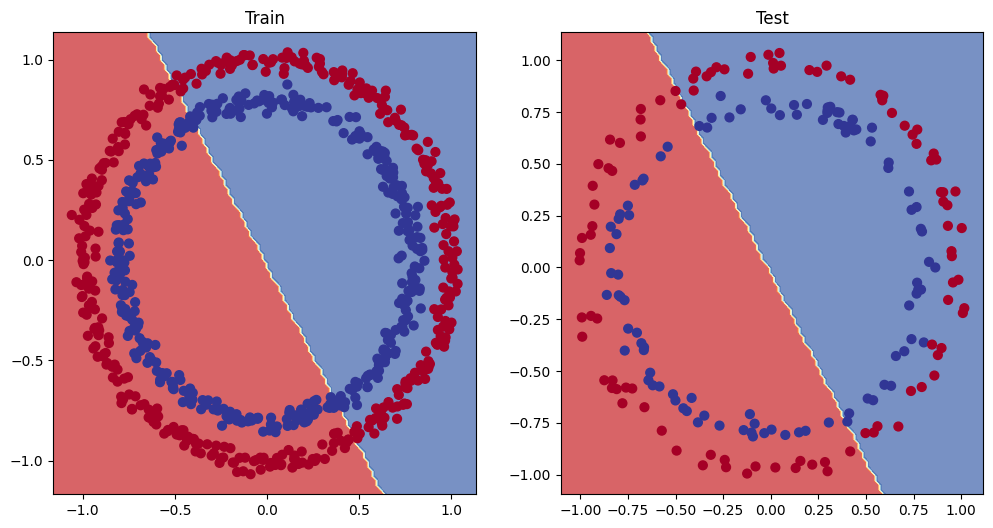

In [50]:
plt.figure(figsize=(12,6))
plt.subplot(1,2 ,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2 ,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

**The model is behaving really bad**
* add more layers 
* add more hidden units
* Fit for longer
* changing the activation function
* change the learning rate
* change the loss function